In [1]:
import srmodels as models
import torch
import torch.nn.functional as F
from skimage import io, transform, img_as_float, color, img_as_ubyte, exposure
import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
class Enhancer:
    
    def __init__(self, config, dropout_rate=0.05, batch_size=512):
        ### store config
        self.config = config
        self.p = dropout_rate
        self.batch_size = batch_size
        ### construct model
        if config["enhancement-type"] == "Self":
            model = models.Generator(1, 16, norm='instance')
            if config["lsm-resolution"] == 512:
                model.load_state_dict(torch.load(os.path.join('model-weights', 'self-512.pth')))
            if config["lsm-resolution"] == 256:
                model.load_state_dict(torch.load(os.path.join('model-weights', 'self-256.pth')))
        if config["enhancement-type"] == "Supervised":
            model = models.Generator(1, 16, norm='instance')
            if config["lsm-resolution"] == 512:
                model.load_state_dict(torch.load(os.path.join('model-weights', 'supervised-512.pth')))
            if config["lsm-resolution"] == 256:
                model.load_state_dict(torch.load(os.path.join('model-weights', 'supervised-256.pth')))
        if config["gpu"] == True:
            self.model = model.cuda()
        else:
            self.model = model
            
    def compute(self, image):
        with torch.no_grad():
            image = img_as_float(image)
            if self.config["exposure-level"] == "mid":
                image = exposure.rescale_intensity(image, in_range=(0.12, 1), out_range=(0, 1))
            if self.config["exposure-level"] == "high":
                image = exposure.rescale_intensity(image, in_range=(0.03, 1), out_range=(0, 1))
            image = exposure.adjust_gamma(image, 0.5)
            image_tensor = torch.from_numpy(image)[None, None, :] # 1x1xHxW
            device = next(self.model.parameters()).device
            image_tensor = image_tensor.float().to(device)
            image_batch = image_tensor.repeat(self.batch_size, 1, 1, 1)
            tensor_hyper = torch.zeros((1, image_tensor.shape[1], image_tensor.shape[2], image_tensor.shape[3]))
            pass_time = int(1/self.p)
            for i in range(pass_time):
                drop_mask = F.dropout(torch.ones(image_batch.shape).float().to(device), p=self.p, inplace=True).to(device)
                real_mid = torch.mul(image_batch, drop_mask) 
                prediction = self.model(image_tensor)
                prediction = torch.mul(prediction, 1/(1-self.p)-drop_mask) / self.p
                tensor_hyper = tensor_hyper + torch.mean(prediction, 0).cpu()
            prediction = tensor_hyper/pass_time
            image = np.clip(prediction.squeeze().cpu().numpy(), 0, 1)
        return image              

In [3]:
config = {
    "enhancement-type" : "Self",
    "lsm-resolution" : 256,
    "gpu" : True,
    "exposure-level" : "mid",
}

In [4]:
enhancer = Enhancer(config)

In [5]:
image = io.imread('data/TMA/input/PA-961e-lsm-v1-A-2/PA-961e-lsm-v1-A-2 [x=6,y=4,w=256,h=256].png')

In [6]:
output = enhancer.compute(image)

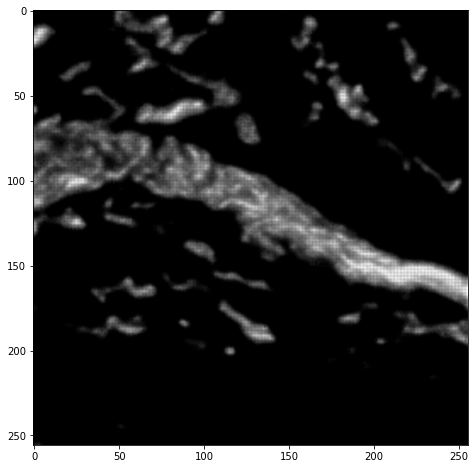

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.imshow(output, cmap='gray', interpolation='bicubic')

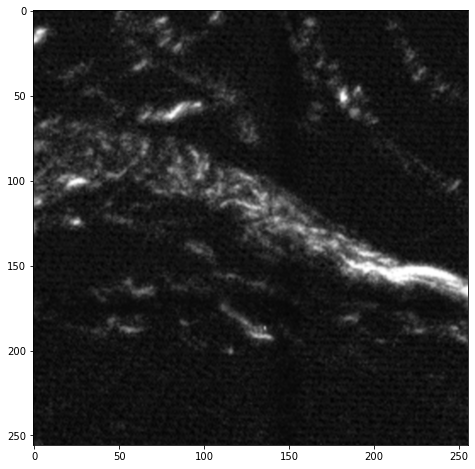

In [68]:
plt.figure(figsize=(8, 8))
plt.imshow(image, cmap='gray', interpolation='bicubic')